In [12]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define paths
train_dir = '/kaggle/input/analog-images/Analog Section/train'
val_dir = '/kaggle/input/analog-images/Analog Section/train'
test_dir = '/kaggle/input/analog-images/Analog Section/test'

# Image dimensions
img_height, img_width = 224, 224

batch_size = 64

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Load the VGG16 model with pretrained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, 
                   input_shape=(img_height, img_width, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
class_weights = {0: 2., 1: 3.}
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                              min_lr=1e-7)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', 
              metrics=['accuracy'])

# Continue training the model
history_fine = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

Found 3120 images belonging to 2 classes.
Found 3120 images belonging to 2 classes.
Found 792 images belonging to 2 classes.
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.5000 - loss: 2.8164 - val_accuracy: 0.5128 - val_loss: 2.7334 - learning_rate: 1.0000e-05
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 44s 793ms/step - accuracy: 0.5057 - loss: 2.7609 - val_accuracy: 0.5128 - val_loss: 2.7149 - learning_rate: 1.0000e-05
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 46s 826ms/step - accuracy: 0.5011 - loss: 2.7357 - val_accuracy: 0.4872 - val_loss: 2.6976 - learning_rate: 1.0000e-05
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 46s 842ms/step - accuracy: 0.4914 - loss: 2.7183 - val_accuracy: 0.4872 - val_loss: 2.6836 - learning_rate: 1.0000e-05
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 47s 853ms/step - accuracy: 0.5151 - loss: 2.6835 - val_accuracy: 0.4872 - val_loss: 2.6706 - learning_rate: 1.0000e-05
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 45s 823ms/step - accuracy: 0.5129 - loss: 2.6691 - val_accuracy: 0.4872 - val_loss: 2.6471 - learning_rate: 1.0000e-05
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 45s 811ms/step - accuracy: 0.5122 

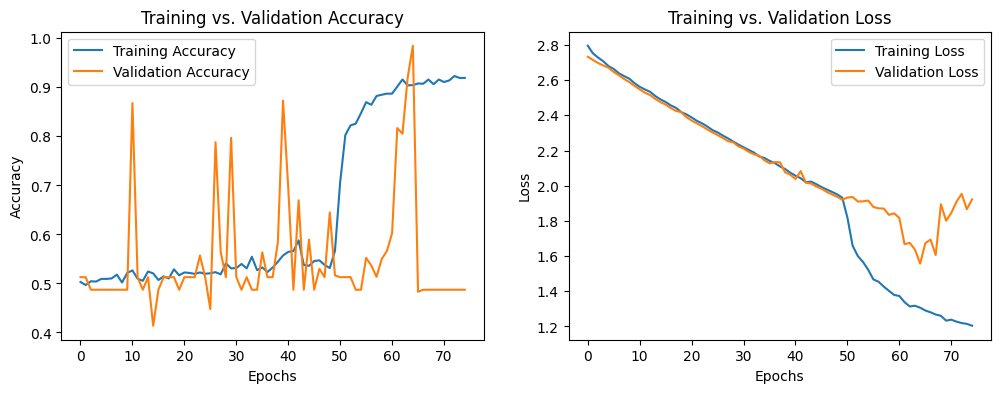

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')

plt.show()

In [21]:
test_generator.reset()
predictions = model.predict(test_generator)
predictions = np.round(predictions).astype(int).flatten()

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step


In [22]:
true_labels = test_generator.classes

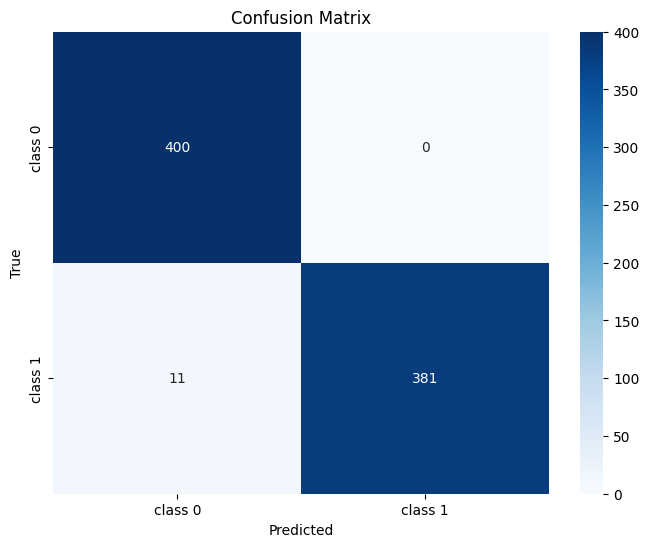

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
report = classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys())
print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

     class 0       0.97      1.00      0.99       400
     class 1       1.00      0.97      0.99       392

    accuracy                           0.99       792
   macro avg       0.99      0.99      0.99       792
weighted avg       0.99      0.99      0.99       792



In [25]:
model.save_weights('best_model.weights.h5')
model_json = model.to_json()
with open("/kaggle/working/best_model.json", "w") as json_file:
    json_file.write(model_json)

In [26]:
import os
os.chdir(r'/kaggle/working')

from IPython.display import FileLink
FileLink(r'best_model.weights.h5')

/kaggle/working/best_model.weights.h5